Importing important libraries

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

Loading images for making model

In [2]:

import os
import shutil

# Define the source folder
source_folder = "/content/drive/MyDrive/chick_or_duck"

# Define the destination folders
train_folder = "/content/drive/MyDrive/chick_or_duck/train"
test_folder = "/content/drive/MyDrive/chick_or_duck/test"
val_folder = "/content/drive/MyDrive/chick_or_duck/val"

In [7]:

import os
import shutil

# Define the source folder
source_folder = "/content/drive/MyDrive/chick_or_duck"

# Define the destination folders
train_folder = "/content/drive/MyDrive/chick_or_duck/train"
test_folder = "/content/drive/MyDrive/chick_or_duck/test"
val_folder = "/content/drive/MyDrive/chick_or_duck/val"

# Create the destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Define the classes
classes = ["duck", "chick"]

# Split the images into train, test, and validation sets
for class_name in classes:
  class_folder = os.path.join(source_folder, class_name)
  images = os.listdir(class_folder)

  # Split the images into train, test, and validation sets
  train_size = int(len(images) * 0.7)
  test_size = int(len(images) * 0.15)
  val_size = len(images) - train_size - test_size

  train_images = images[:train_size]
  test_images = images[train_size:train_size+test_size]
  val_images = images[train_size+test_size:]

  os.makedirs(train_folder + '/' + class_name, exist_ok=True)
  os.makedirs(test_folder + '/' + class_name, exist_ok=True)
  os.makedirs(val_folder + '/' + class_name, exist_ok=True)

  # Copy the images to the destination folders
  for image in train_images:
    source_path = os.path.join(class_folder, image)
    shutil.copy(source_path, train_folder + '/' + class_name)

  for image in test_images:
    source_path = os.path.join(class_folder, image)
    shutil.copy(source_path, test_folder + '/' + class_name)

  for image in val_images:
    source_path = os.path.join(class_folder, image)
    shutil.copy(source_path, val_folder + '/' + class_name)


Transforming image data into trainable format

In [58]:
x_train=[]

for folder in os.listdir(train_folder):

    sub_path=train_folder+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_folder):

    sub_path=test_folder+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_folder):

    sub_path=val_folder+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

In [59]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [60]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse',
                                                 shuffle = True)
test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                                 shuffle = True)
val_set = val_datagen.flow_from_directory(val_folder,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse',
                                                 shuffle = True)

Found 140 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [61]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

Implementing transfer learning using vgg19 and experimenting with different model checkpoints to find the optimal model

In [62]:
vgg = VGG19(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [63]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification


x = Dense(12, activation="relu")(x)
x = Dense(24, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(36, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(24, activation="relu")(x)
x = Dense(12, activation="relu")(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [64]:
# view the structure of the model
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [65]:
model.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model
least_loss = ModelCheckpoint(
    filepath='least_loss',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

max_acc = ModelCheckpoint(
    filepath='max_acc',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [67]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=50,
  callbacks=[early_stop, least_loss, max_acc],
  batch_size=32,shuffle=True)

Epoch 1/50
5/5 [==============================] - 11s 2s/step - loss: 0.7292 - accuracy: 0.4643 - val_loss: 0.7037 - val_accuracy: 0.5000
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.6762 - accuracy: 0.5500 - val_loss: 0.6717 - val_accuracy: 0.7000
Epoch 3/50
5/5 [==============================] - 4s 991ms/step - loss: 0.6208 - accuracy: 0.5429 - val_loss: 0.6463 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 4s 886ms/step - loss: 0.5871 - accuracy: 0.5000 - val_loss: 0.6164 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.5247 - accuracy: 0.7857 - val_loss: 0.5740 - val_accuracy: 0.7667
Epoch 6/50
5/5 [==============================] - 4s 982ms/step - loss: 0.4606 - accuracy: 0.7786 - val_loss: 0.5154 - val_accuracy: 0.7000
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.4138 - accuracy: 0.8786 - val_loss: 0.4728 - val_accuracy: 0.8333
Epoch 8/50
5/5 [===============

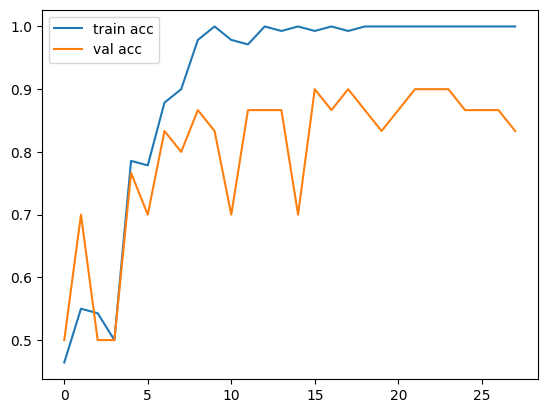

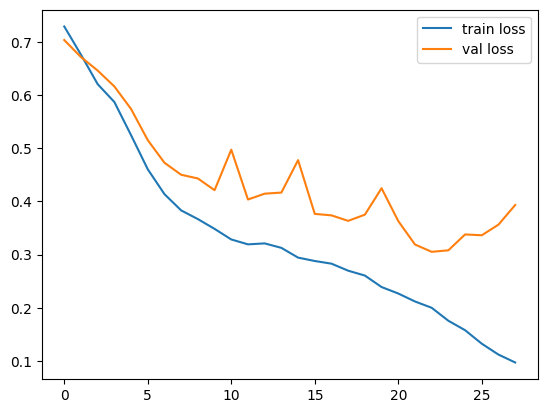

In [68]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()


In [69]:
model.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 0s 220ms/step - loss: 0.4692 - accuracy: 0.8000


[0.4692491888999939, 0.800000011920929]

In [71]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification


x = Dense(12, activation="relu")(x)
x = Dense(24, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(36, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(24, activation="relu")(x)
x = Dense(12, activation="relu")(x)
prediction = Dense(1, activation='sigmoid')(x)

model_loss = Model(inputs=vgg.input, outputs=prediction)

In [73]:
model_loss.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [74]:
model_loss.load_weights('/content/least_loss')

In [75]:
model_loss.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 1s 879ms/step - loss: 0.2810 - accuracy: 0.9333


[0.2809551954269409, 0.9333333373069763]

In [77]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification


x = Dense(12, activation="relu")(x)
x = Dense(24, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(36, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(24, activation="relu")(x)
x = Dense(12, activation="relu")(x)
prediction = Dense(1, activation='sigmoid')(x)

model_acc = Model(inputs=vgg.input, outputs=prediction)

In [78]:
model_acc.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [79]:
model_acc.load_weights('/content/max_acc')

In [80]:
model_acc.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 1s 872ms/step - loss: 0.3655 - accuracy: 0.8667


[0.3654993772506714, 0.8666666746139526]

In [83]:

shutil.move('/content/max_acc', '/content/drive/MyDrive/chick_or_duck')

'/content/drive/MyDrive/chick_or_duck/max_acc'

model_loss is the best model from the above stated models